# calculate the trancription of all the audio files in the dataset

## with batch

In [ ]:
import pandas as pd
import os
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import torch
import librosa
import numpy as np
from tqdm import tqdm  # Progress bar

# Load model and processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

# Check for multiple GPUs
device_ids = list(range(torch.cuda.device_count()))  # List of GPU ids
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Wrap the model with DataParallel
model = torch.nn.DataParallel(model, device_ids=device_ids)
model.to(device)

root_folders = ['/data/Vaani/Dataset/Audios_all_district_vaani_3']

# Function to get transcriptions for a batch of files
def get_transcriptions(file_paths):
    input_values_list = []
    file_path_map = {}
    
    for file_path in file_paths:
        if os.path.exists(file_path):
            audio, sr = librosa.load(file_path, sr=None)
            input_values = processor(audio, return_tensors="pt", padding="longest", sampling_rate=sr).input_values
            input_values_list.append(input_values)
            file_path_map[input_values_list[-1]] = file_path
    
    # Pad the sequences to the same length
    max_length = max(input_values.size(1) for input_values in input_values_list)
    padded_inputs = torch.zeros((len(input_values_list), max_length))
    
    for i, input_values in enumerate(input_values_list):
        padded_inputs[i, :input_values.size(1)] = input_values.squeeze()

    input_values_batch = padded_inputs.to(device)

    with torch.no_grad():  # Disable gradient calculations
        logits = model(input_values_batch).logits

    predicted_ids = torch.argmax(logits, dim=-1)
    transcriptions = processor.batch_decode(predicted_ids)
    
    # Map file paths to transcriptions
    return dict(zip(file_path_map.values(), transcriptions))

batch_size = 64
file_paths = []

# Create lists to store file information
file_data = {
    "File Name": [],
    "Duration": [],
    "Byte Size": [],
    "Transcription": []
}

# Process each folder and display progress with tqdm
for root_folder in root_folders:
    for subdir, _, files in os.walk(root_folder):
        print(f"Processing directory: {subdir}")
        files.sort()
        
        # Use tqdm for the files loop to track progress
        for audio_file in tqdm(files, desc=f"Processing files in {subdir}"):
            if audio_file.endswith('.wav'):
                audio_file_path = os.path.join(subdir, audio_file)
                file_paths.append(audio_file_path)
                
                # Get file information
                duration = librosa.get_duration(filename=audio_file_path)
                byte_size = os.path.getsize(audio_file_path)
                
                file_data["File Name"].append(audio_file_path)
                file_data["Duration"].append(duration)
                file_data["Byte Size"].append(byte_size)
                
                # Process in batches
                if len(file_paths) >= batch_size:
                    transcriptions = get_transcriptions(file_paths[:batch_size])
                    for file, transcription in transcriptions.items():
                        file_data["Transcription"].append(transcription)
                    file_paths = file_paths[batch_size:]

# Process remaining files if they don't fit exactly into the batch size
if file_paths:
    transcriptions = get_transcriptions(file_paths)
    for file, transcription in transcriptions.items():
        file_data["Transcription"].append(transcription)

# Create DataFrame from collected data
df = pd.DataFrame(file_data)

# Save the DataFrame to a CSV file
output_csv_path = "/data/Root_content/Vaani/audio_content_analysis/audio_analysis_all_group/temp.csv"
df.to_csv(output_csv_path, index=False)

print(f"CSV file saved to {output_csv_path}")


## without batch

In [ ]:
import pandas as pd
import os
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import torch
import librosa
import numpy as np
from tqdm import tqdm  # Progress bar

# Load model and processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

# Check for multiple GPUs
device_ids = list(range(torch.cuda.device_count()))  # List of GPU ids
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Wrap the model with DataParallel if using multiple GPUs
model = torch.nn.DataParallel(model, device_ids=device_ids)
model.to(device)

root_folders = ['/data/Vaani/Dataset/Audios_all_district_vaani_3']

# Function to get transcription for a single file
def get_transcription(file_path):
    if os.path.exists(file_path):
        audio, sr = librosa.load(file_path, sr=None)
        input_values = processor(audio, return_tensors="pt", padding="longest", sampling_rate=sr).input_values.to(device)

        with torch.no_grad():  # Disable gradient calculations
            logits = model(input_values).logits

        predicted_ids = torch.argmax(logits, dim=-1)
        transcription = processor.batch_decode(predicted_ids)[0]
        return transcription
    
    return None

# Create lists to store file information
file_data = {
    "File Name": [],
    "Duration": [],
    "Byte Size": [],
    "Transcription": []
}

# Process each folder and display progress with tqdm
for root_folder in root_folders:
    for subdir, _, files in os.walk(root_folder):
        print(f"Processing directory: {subdir}")
        files.sort()
        
        # Use tqdm for the files loop to track progress
        for audio_file in tqdm(files, desc=f"Processing files in {subdir}"):
            if audio_file.endswith('.wav'):
                audio_file_path = os.path.join(subdir, audio_file)

                # Get file information
                duration = librosa.get_duration(filename=audio_file_path)
                byte_size = os.path.getsize(audio_file_path)

                # Get transcription
                transcription = get_transcription(audio_file_path)

                # Append file info to the data
                file_data["File Name"].append(audio_file_path)
                file_data["Duration"].append(duration)
                file_data["Byte Size"].append(byte_size)
                file_data["Transcription"].append(transcription)

# Create DataFrame from collected data
df = pd.DataFrame(file_data)

# Save the DataFrame to a CSV file
output_csv_path = "/data/Root_content/Vaani/audio_content_analysis/audio_analysis_all_group/temp.csv"
df.to_csv(output_csv_path, index=False)

print(f"CSV file saved to {output_csv_path}")


# concatenate all the csv file

In [1]:
import pandas as pd
import os

# List of CSV file paths
csv_files = ["/data/Root_content/Vaani/audio_content_analysis/audio_analysis_all_group/audio_transcription_csv/audio_trancription_without_batching_1.csv", 
             "/data/Root_content/Vaani/audio_content_analysis/audio_analysis_all_group/audio_transcription_csv/audio_trancription_without_batching_2.csv", 
             "/data/Root_content/Vaani/audio_content_analysis/audio_analysis_all_group/audio_transcription_csv/audio_trancription_without_batching_3.csv", 
             "/data/Root_content/Vaani/audio_content_analysis/audio_analysis_all_group/audio_transcription_csv/audio_trancription_without_batching_4.csv", 
             "/data/Root_content/Vaani/audio_content_analysis/audio_analysis_all_group/audio_transcription_csv/audio_trancription_without_batching_5.csv", 
             "/data/Root_content/Vaani/audio_content_analysis/audio_analysis_all_group/audio_transcription_csv/audio_trancription_without_batching_6.csv"]

# Read and concatenate all CSV files into one DataFrame
combined_df = pd.concat([pd.read_csv(file) for file in csv_files])

# Save the combined DataFrame to a new CSV file
combined_df.to_csv("audio_trancription_without_batching_all.csv", index=False)

print("CSV files concatenated successfully!")


CSV files concatenated successfully!


# convert the filename to link

In [2]:
import pandas as pd

# Load the CSV file
csv_file = '/data/Root_content/Vaani/audio_content_analysis/audio_analysis_all_group/audio_transcription_csv/audio_trancription_without_batching_all.csv'  # Replace with the path to your actual CSV file
df = pd.read_csv(csv_file)

# Function to convert filename
def convert_filename(filename):
    base_name = filename.split("/")[-1]
    new_filename = "https://vaani.iisc.ac.in/Audios/" + base_name.split('_')[4] + "/" + base_name
    return new_filename

# Replace the 'File Name' column with the converted filenames
df['File Name'] = df['File Name'].apply(convert_filename)

# Save the modified DataFrame to a new CSV file
output_csv = '/data/Root_content/Vaani/audio_content_analysis/audio_analysis_all_group/audio_link_trancription_without_batching_all.csv'  # Replace with the desired output file path
df.to_csv(output_csv, index=False)

print(f"Converted file saved to {output_csv}")

Converted file saved to /data/Root_content/Vaani/audio_content_analysis/audio_analysis_all_group/audio_link_trancription_without_batching_all.csv


In [4]:
print(df['File Name'][0])

https://vaani.iisc.ac.in/Audios/Sukma/IISc_VaaniProject_S_Chhattisgarh_Sukma_114191_12208498_APCTFLM_226630_7402_11502.wav


# remove the duplicate filenames

In [5]:
import pandas as pd

# Load the CSV file
csv_file_path = "/data/Root_content/Vaani/audio_content_analysis/audio_analysis_all_group/audio_transcription_csv/audio_link_trancription_without_batching_all.csv"  # Update with the actual path
df = pd.read_csv(csv_file_path)

# Remove duplicate file names
df_cleaned = df.drop_duplicates(subset=['File Name'])

# Save the cleaned DataFrame back to a CSV file
output_csv_file = "/data/Root_content/Vaani/audio_content_analysis/audio_analysis_all_group/audio_link_trancription_without_batching_all_removed_duplicates.csv"  # Update with the desired output path
df_cleaned.to_csv(output_csv_file, index=False)

print(f"Cleaned CSV file saved to: {output_csv_file}")


Cleaned CSV file saved to: /data/Root_content/Vaani/audio_content_analysis/audio_analysis_all_group/audio_link_trancription_without_batching_all_removed_duplicates.csv


In [7]:
df = pd.read_csv('/data/Root_content/Vaani/audio_content_analysis/audio_analysis_all_group/audio_transcription_csv/audio_link_trancription_without_batching_all.csv')
print(df)

                                                 File Name   Duration  \
0        https://vaani.iisc.ac.in/Audios/Sukma/IISc_Vaa...   4.100000   
1        https://vaani.iisc.ac.in/Audios/Sukma/IISc_Vaa...   5.560000   
2        https://vaani.iisc.ac.in/Audios/Sukma/IISc_Vaa...   9.192000   
3        https://vaani.iisc.ac.in/Audios/Sukma/IISc_Vaa...   8.775000   
4        https://vaani.iisc.ac.in/Audios/Sukma/IISc_Vaa...  12.440000   
...                                                    ...        ...   
6715229  https://vaani.iisc.ac.in/Audios/North24P/IISc_...   7.093312   
6715230  https://vaani.iisc.ac.in/Audios/North24P/IISc_...   5.418687   
6715231  https://vaani.iisc.ac.in/Audios/North24P/IISc_...   2.069313   
6715232  https://vaani.iisc.ac.in/Audios/North24P/IISc_...   3.914687   
6715233  https://vaani.iisc.ac.in/Audios/North24P/IISc_...   5.589313   

         Byte Size                                      Transcription  
0           132498  O E DEY WE TIO SO POR OMO A HAI

In [6]:
df = pd.read_csv('/data/Root_content/Vaani/audio_content_analysis/audio_analysis_all_group/audio_link_trancription_without_batching_all_removed_duplicates.csv')
print(df)

                                                 File Name   Duration  \
0        https://vaani.iisc.ac.in/Audios/Sukma/IISc_Vaa...   4.100000   
1        https://vaani.iisc.ac.in/Audios/Sukma/IISc_Vaa...   5.560000   
2        https://vaani.iisc.ac.in/Audios/Sukma/IISc_Vaa...   9.192000   
3        https://vaani.iisc.ac.in/Audios/Sukma/IISc_Vaa...   8.775000   
4        https://vaani.iisc.ac.in/Audios/Sukma/IISc_Vaa...  12.440000   
...                                                    ...        ...   
5908590  https://vaani.iisc.ac.in/Audios/North24P/IISc_...   7.093312   
5908591  https://vaani.iisc.ac.in/Audios/North24P/IISc_...   5.418687   
5908592  https://vaani.iisc.ac.in/Audios/North24P/IISc_...   2.069313   
5908593  https://vaani.iisc.ac.in/Audios/North24P/IISc_...   3.914687   
5908594  https://vaani.iisc.ac.in/Audios/North24P/IISc_...   5.589313   

         Byte Size                                      Transcription  
0           132498  O E DEY WE TIO SO POR OMO A HAI

# split rows of the csv based on the group


In [8]:
import pandas as pd
import os

# Load the CSV file
csv_file_path = '/data/Root_content/Vaani/audio_content_analysis/audio_analysis_all_group/audio_transcription_without_batch/audio_transcription_csv/audio_link_trancription_without_batching_all_removed_duplicates.csv'  # Replace with your file path
df = pd.read_csv(csv_file_path)

# Group by 'Byte Size' column
grouped = df.groupby('Byte Size')

# Create an output directory
output_dir = '/data/Root_content/Vaani/audio_content_analysis/audio_analysis_all_group/audio_transcription_without_batch/csv_group_wise/'  # Replace with your output directory
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save each group into a separate CSV file
for byte_size, group in grouped:
    if len(group) > 1:  # Only save if the group has more than one row
        output_file = os.path.join(output_dir, f'group_{byte_size}.csv')
        group.to_csv(output_file, index=False)

print("CSV files created for each group.")


CSV files created for each group.


# apply the FAISS algo on all the groups

In [ ]:
import os
import pandas as pd
import faiss
from sentence_transformers import SentenceTransformer
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_core.documents import Document
import numpy as np
from tqdm import tqdm

# Initialize the Sentence Transformer model
model_name = "sentence-transformers/all-mpnet-base-v2"
model = SentenceTransformer(model_name)

# Define the input and output folder paths
input_folder_path = "/data/Root_content/Vaani/audio_content_analysis/audio_analysis_all_group/csv_group_wise"
output_folder_path = "/data/Root_content/Vaani/audio_content_analysis/audio_analysis_all_group/csv_group_wise_similarity"

if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

# Loop through each CSV file in the input folder
for csv_filename in tqdm(os.listdir(input_folder_path), desc= f"Processing CSVs"):
    if csv_filename.endswith(".csv"):
        # Construct the full path of the current CSV file
        csv_file_path = os.path.join(input_folder_path, csv_filename)
        
        # Load the CSV file containing transcriptions
        df = pd.read_csv(csv_file_path)
        print("df length = ", len(df))
        
        # Check if 'Transcription' column exists in the CSV
        if 'Transcription' not in df.columns:
            print(f"Skipping {csv_filename} as it does not contain 'Transcription' column.")
            continue
        
        # Generate embeddings for each transcription
        df['Transcription'] = df['Transcription'].fillna('')
        transcriptions = df['Transcription'].tolist()
        filenames = df['File Name'].tolist()
        embedding_vectors = model.encode(transcriptions)
        
        # Normalize embeddings to use cosine similarity
        embedding_vectors = embedding_vectors / np.linalg.norm(embedding_vectors, axis=1, keepdims=True)
        
        # Initialize FAISS index for inner product (cosine similarity)
        dimension = embedding_vectors.shape[1]
        index = faiss.IndexFlatIP(dimension)
        index.add(embedding_vectors)
        
        # Create a dictionary with filenames as keys and transcriptions as values
        transcription_dict = {filename: transcription for filename, transcription in zip(filenames, transcriptions)}
        
        # Create a reverse dictionary to map transcriptions back to filenames
        reverse_transcription_dict = {transcription: filename for filename, transcription in transcription_dict.items()}
        
        # Create a document store with filenames as keys
        docstore = InMemoryDocstore({filename: Document(page_content=transcription) for filename, transcription in transcription_dict.items()})
        index_to_docstore_id = {i: filename for i, filename in enumerate(filenames)}
        
        # Create FAISS vector store
        vector_store = FAISS(
            embedding_function=lambda x: model.encode(x),
            index=index,
            docstore=docstore,
            index_to_docstore_id=index_to_docstore_id
        )
        
        # Prepare a list to store results
        results_list = []
        
        # Perform a similarity search for each transcription
        for filename, query in transcription_dict.items():
            try:
                search_results = vector_store.similarity_search_with_score(query, k=2)  # k=2 to get top 2 similar transcriptions
                
                for res, score in search_results:
                    # Extract the transcription from the result
                    result_transcription = res.page_content
                    
                    # Use the reverse dictionary to get the filename for the result transcription
                    result_filename = reverse_transcription_dict.get(result_transcription, None)
                    
                    if result_filename is None:
                        print(f"Result transcription not found in reverse dictionary: {result_transcription}")
                        continue
                    
                    if result_filename == filename:  # Skip the result of the query itself
                        continue
                    
                    result_row = {
                        "Filename_1": filename,
                        "Filename_2": result_filename,
                        "Similarity_score": round(score, 3)
                    }
                    results_list.append(result_row)
            except Exception as e:
                print(f"Skipping file {filename} due to error: {e}")
        
        # Save the results for the current CSV file
        output_csv_filename = f"similarity_results_{csv_filename.split('.')[0]}_size_{len(df)}.csv"
        output_csv_file_path = os.path.join(output_folder_path, output_csv_filename)
        
        results_df = pd.DataFrame(results_list)
        results_df.to_csv(output_csv_file_path, index=False)

        print(f"Similarity results for {csv_filename} saved to {output_csv_file_path}.")


# remove the duplicates

In [1]:
import pandas as pd
import os
from tqdm import tqdm

# Load the CSV file
input_folder_path = '/data/Root_content/Vaani/audio_content_analysis/audio_analysis_all_group/audio_transcription_without_batch/csv_group_wise_similarity'
output_folder_path = '/data/Root_content/Vaani/audio_content_analysis/audio_analysis_all_group/audio_transcription_without_batch/csv_group_wise_similarity_unique'

if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

for csv_file in tqdm(os.listdir(input_folder_path)):

    try:
        file_path = os.path.join(input_folder_path, csv_file)
        
        df = pd.read_csv(file_path)

        # Create a set to track unique pairs
        unique_pairs = set()

        # Function to create an unordered pair as a tuple
        def make_pair(row):
            return tuple(sorted([row['Filename_1'], row['Filename_2']]))

        # Identify and remove duplicate pairs
        filtered_rows = []
        for _, row in df.iterrows():
            pair = make_pair(row)
            if pair not in unique_pairs:
                unique_pairs.add(pair)
                filtered_rows.append(row)

        # Create a new DataFrame with the filtered rows
        filtered_df = pd.DataFrame(filtered_rows)
        output_file_path = os.path.join(output_folder_path, csv_file) 
        filtered_df.to_csv(output_file_path, index=False)
    except Exception as e:
        print(f"Skipping file because of the error: {e}")

    # print(f"Cleaned CSV saved to {output_file_path}")


100%|██████████| 67507/67507 [10:22<00:00, 108.42it/s]


# counting number of pairs with similarity score 1, >.95, >.9

In [2]:
import pandas as pd
import os
from tqdm import tqdm

# Folder path containing the CSV files
folder_path = '/data/Root_content/Vaani/audio_content_analysis/audio_analysis_all_group/audio_transcription_without_batch/csv_group_wise_similarity_unique'

# List to store the results
results = []

# Loop through each file in the folder
for filename in tqdm(os.listdir(folder_path)):
    if filename.endswith(".csv"):
        # Read the CSV file
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        
        # Count the number of rows for each similarity score condition
        count_exact_1 = df[df['Similarity_score'] == 1].shape[0]
        count_95_to_1 = df[(df['Similarity_score'] >= 0.95) & (df['Similarity_score'] < 1)].shape[0]
        count_90_to_95 = df[(df['Similarity_score'] >= 0.9) & (df['Similarity_score'] < 0.95)].shape[0]
        count_80_to_90 = df[(df['Similarity_score'] >= 0.8) & (df['Similarity_score'] < 0.9)].shape[0]

        group_name = '_'.join(filename.split('_')[2:]).split('.')[0]
        byte_size = group_name.split('_')[1]
        number_of_files_in_group = group_name.split('_')[3]
        number_of_pairs_in_group = len(df)
        #print(len(df))
        
        # Append the results to the list
        results.append([group_name, byte_size, number_of_files_in_group, number_of_pairs_in_group, count_exact_1, count_95_to_1, count_90_to_95, count_80_to_90])

# Create a DataFrame for the results
results_df = pd.DataFrame(results, columns=['Group_name_size',
                                            'Byte_size',
                                            'Number of files',
                                            'Number of pairs in similarity results',
                                            'NO. of pairs with similarity score equals 1', 
                                            'NO. of pairs with 0.95 <= similarity score < 1', 
                                            'NO. of pairs with 0.9 <= similarity score < .95',
                                            'NO. of pairs with 0.8 <= similarity score < .9'])

# Save the results to a new CSV file
output_file = 'similarity_analysis.csv'
results_df.to_csv(output_file, index=False)

print(f'Results saved to {output_file}')


  0%|          | 0/67507 [00:00<?, ?it/s]

100%|██████████| 67507/67507 [03:28<00:00, 323.23it/s]


Results saved to similarity_analysis.csv


# plot between byte size and similarity score 1

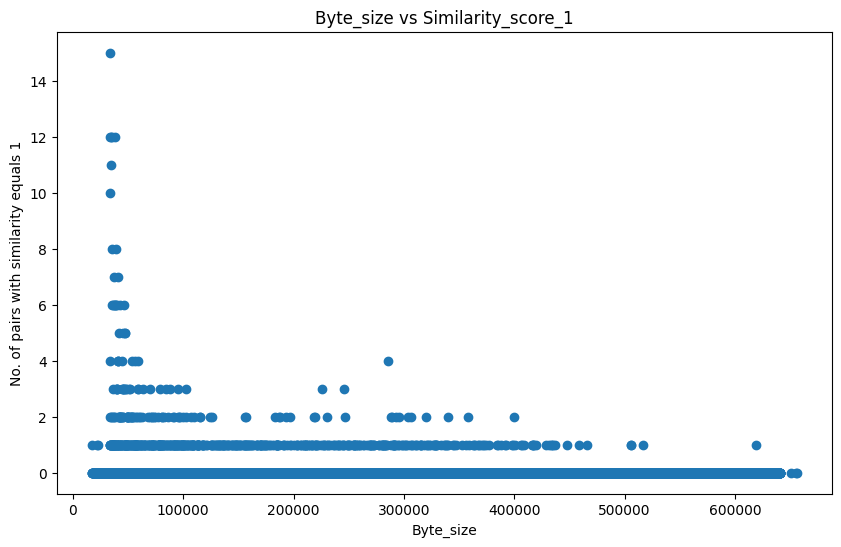

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/data/Root_content/Vaani/audio_content_analysis/audio_analysis_all_group/audio_transcription_without_batch/similarity_analysis.csv')

plt.figure(figsize=(10,6))
plt.scatter(df['Byte_size'], df['NO. of pairs with similarity score equals 1'])
plt.title("Byte_size vs Similarity_score_1")
plt.xlabel("Byte_size")
plt.ylabel("No. of pairs with similarity equals 1")
plt.show()

